In [1]:
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import contractions
from imblearn.over_sampling import SMOTE
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from keras import regularizers
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
%matplotlib inline

Using TensorFlow backend.
/Users/soudeh/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/soudeh/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/soudeh/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/soud

In [2]:
numberofwords = 10000  # Parameter indicating the number of words we'll put in the dictionary
valuesize = 1000  # Size of the validation set
numberofstartepochs = 20  # Number of epochs we usually start to train with
batchsize = 512  # Size of the batches used in the mini-batch gradient descent

In [3]:
tweet=pd.read_csv('data.csv')
tweet.head()
tweet = tweet[['airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
               'airline', 'text']]
tweet.head()


,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text
0,neutral,1.0000,NaN,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...


In [4]:
def text_cleaning(text):
    #remove stop words
    text=' '.join([word for word in text.split() if word not in (stopwords.words('english'))])

    #apply lowercase
    text=text.lower()

    #remove punctuations
    text=text.translate(str.maketrans('','',string.punctuation))
    
    #apply decontraction
    expanded_words =[]
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    text = ' '.join(expanded_words)
    
    #delete emojy
    emoji_pattern = re.compile('[' u'\U0001F600-\U0001F64F' u'\U0001F300-\U0001F5FF'
                                u'\U0001F680-\U0001F6CF' u'\U0001F3C1-\U0001F3F4'
                                u'\U00002702-\U000027B0' u'\U000024C2-\U0001F251' ']+', flags=re.UNICODE)
    text=emoji_pattern.sub(r'', text)

    #delete url
    text=re.sub('http\S+', '', text)

    #delete hashtag
    text=re.sub('#[A-Za-z0-9_]+', '', text)

    #delete username
    text=re.sub('@[A-Za-z0-9_]+', '', text)


    
    return text

In [5]:
tweet['text']=tweet['text'].apply(lambda x: text_cleaning(x))


In [6]:
def compute_performance(yhat, y, classes):
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    sensitivity = recall
    specificity = tn / (fp + tn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Accuracy:", round(acc, 3), "Recall:", round(recall, 3), "Precision:", round(precision, 3), "F1-Score:",
          round(f1_score, 3),
          "Sensitivity:", round(sensitivity, 3), "Specificity:", round(specificity, 3))

def plot_confusion(cm, name):
    plt.figure(figsize=(6, 4))
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(cm, cmap=plt.cm.PuRd, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Real', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.savefig(name + '_cf.png')

def convert_sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0

def multi_auc(y_prob_pred_cnb, y_test):
    from sklearn.metrics import roc_curve, roc_auc_score
    roc_auc_score(y_test, y_prob_pred_cnb, multi_class='ovo', average='weighted')
    fpr = {}
    tpr = {}
    thresh ={}
    n_class = 3

    for i in range(n_class):
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)

    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)

tweet.airline_sentiment = tweet.airline_sentiment.apply(lambda x: convert_sentiment(x))

In [7]:
tweet['final_text'] = tweet['text']
X = tweet['final_text']
y = tweet['airline_sentiment']
tfid = TfidfVectorizer()
X_final = tfid.fit_transform(X)
smote = SMOTE()
x_sm, y_sm = smote.fit_resample(X_final, y)

X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=37)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

0.7552206282912657


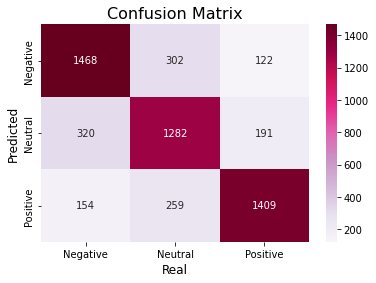

tp: 1282 tn: 1468 fp: 302 fn: 320
Accuracy: 0.816 Recall: 0.8 Precision: 0.809 F1-Score: 0.805 Sensitivity: 0.8 Specificity: 0.829
tp: 1027 tn: 1135 fp: 258 fn: 285
Accuracy: 0.799 Recall: 0.783 Precision: 0.799 F1-Score: 0.791 Sensitivity: 0.783 Specificity: 0.815
tp: 5442 tn: 5340 fp: 326 fn: 257
Accuracy: 0.949 Recall: 0.955 Precision: 0.943 F1-Score: 0.949 Sensitivity: 0.955 Specificity: 0.942


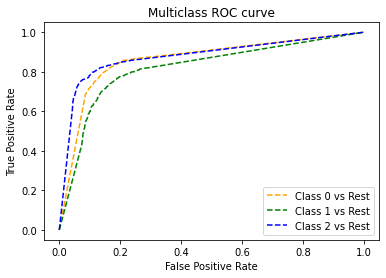

In [8]:
def decision_tree(X_train, y_train, X_test, X_valid):
    clf = DecisionTreeClassifier(min_samples_split=55)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    # text_representation = tree.export_text(clf)
    # print(text_representation)
    # fig = plt.figure(figsize=(25,20))
    # _ = tree.plot_tree(clf, filled=True)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_


dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = decision_tree(X_train, y_train, X_test, X_valid)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'DT')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)

0.8002542218994008


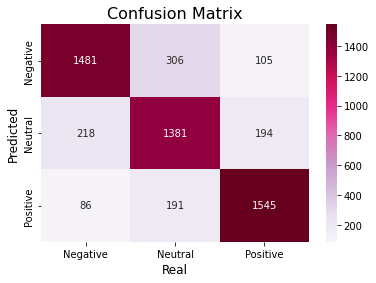

tp: 1381 tn: 1481 fp: 306 fn: 218
Accuracy: 0.845 Recall: 0.864 Precision: 0.819 F1-Score: 0.841 Sensitivity: 0.864 Specificity: 0.829
tp: 1139 tn: 1149 fp: 266 fn: 178
Accuracy: 0.837 Recall: 0.865 Precision: 0.811 F1-Score: 0.837 Sensitivity: 0.865 Specificity: 0.812
tp: 5046 tn: 4831 fp: 792 fn: 422
Accuracy: 0.891 Recall: 0.923 Precision: 0.864 F1-Score: 0.893 Sensitivity: 0.923 Specificity: 0.859


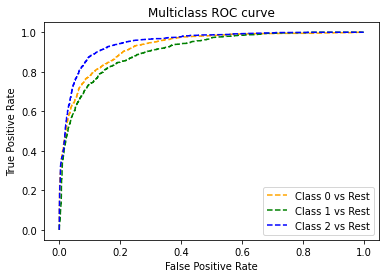

In [9]:
def random_forest(X_train, y_train, X_test, X_valid):
    clf = RandomForestClassifier(max_depth=20, random_state=5)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_

dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = random_forest(X_train, y_train, X_test, X_valid)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'RF')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)

0.8494643181405483


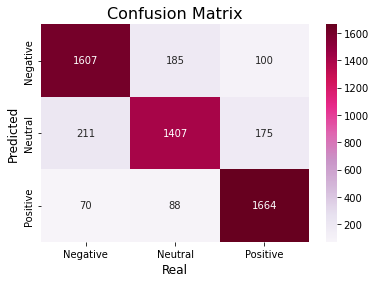

tp: 1407 tn: 1607 fp: 185 fn: 211
Accuracy: 0.884 Recall: 0.87 Precision: 0.884 F1-Score: 0.877 Sensitivity: 0.87 Specificity: 0.897
tp: 1119 tn: 1241 fp: 161 fn: 189
Accuracy: 0.871 Recall: 0.856 Precision: 0.874 F1-Score: 0.865 Sensitivity: 0.856 Specificity: 0.885
tp: 4981 tn: 5303 fp: 319 fn: 525
Accuracy: 0.924 Recall: 0.905 Precision: 0.94 F1-Score: 0.922 Sensitivity: 0.905 Specificity: 0.943


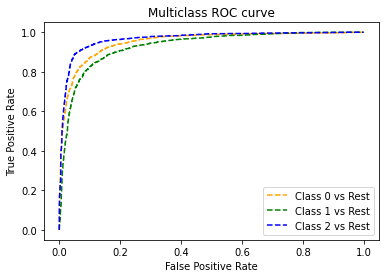

In [10]:
def multinomial_nb(X_train, y_train, X_test, X_valid, alpha):
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_


dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = multinomial_nb(X_train, y_train, X_test, X_valid, 1)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'NB')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)


0.6903940439440712


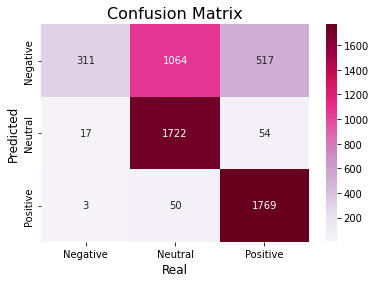

tp: 1722 tn: 311 fp: 1064 fn: 17
Accuracy: 0.653 Recall: 0.99 Precision: 0.618 F1-Score: 0.761 Sensitivity: 0.99 Specificity: 0.226
tp: 1395 tn: 229 fp: 880 fn: 11
Accuracy: 0.646 Recall: 0.992 Precision: 0.613 F1-Score: 0.758 Sensitivity: 0.992 Specificity: 0.206
tp: 5869 tn: 5800 fp: 6 fn: 39
Accuracy: 0.996 Recall: 0.993 Precision: 0.999 F1-Score: 0.996 Sensitivity: 0.993 Specificity: 0.999


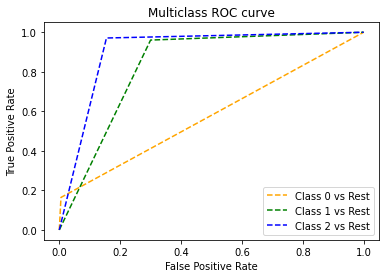

In [11]:
def knn(X_train, y_train, X_test, X_valid, k):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)   
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_

dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = knn(X_train, y_train, X_test, X_valid, 1)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'KNN')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)

0.8485563827855457


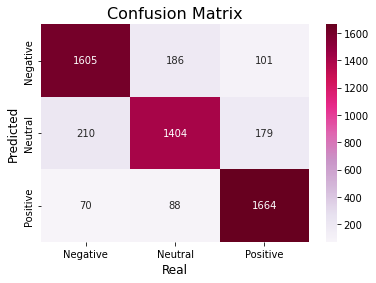

tp: 1404 tn: 1605 fp: 186 fn: 210
Accuracy: 0.884 Recall: 0.87 Precision: 0.883 F1-Score: 0.876 Sensitivity: 0.87 Specificity: 0.896
tp: 1116 tn: 1237 fp: 166 fn: 188
Accuracy: 0.869 Recall: 0.856 Precision: 0.871 F1-Score: 0.863 Sensitivity: 0.856 Specificity: 0.882
tp: 4965 tn: 5275 fp: 337 fn: 537
Accuracy: 0.921 Recall: 0.902 Precision: 0.936 F1-Score: 0.919 Sensitivity: 0.902 Specificity: 0.94


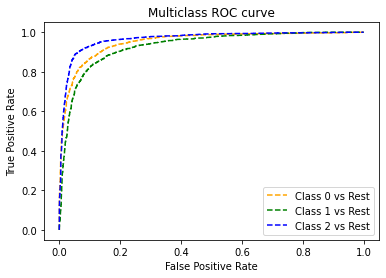

In [12]:
def bagging(X_train, y_train, X_test, X_valid):
    clf = BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=500, random_state=10)
    # clf = BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=5)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_

dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = bagging(X_train, y_train, X_test, X_valid)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'Bagging')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)

0.8714363537316143


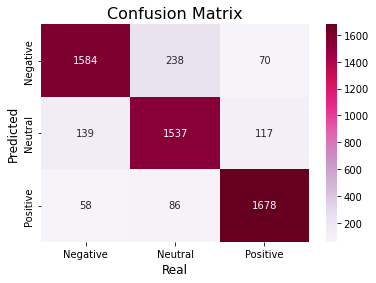

tp: 1537 tn: 1584 fp: 238 fn: 139
Accuracy: 0.892 Recall: 0.917 Precision: 0.866 F1-Score: 0.891 Sensitivity: 0.917 Specificity: 0.869
tp: 1260 tn: 1216 fp: 219 fn: 119
Accuracy: 0.88 Recall: 0.914 Precision: 0.852 F1-Score: 0.882 Sensitivity: 0.914 Specificity: 0.847
tp: 5461 tn: 5390 fp: 329 fn: 238
Accuracy: 0.95 Recall: 0.958 Precision: 0.943 F1-Score: 0.951 Sensitivity: 0.958 Specificity: 0.942


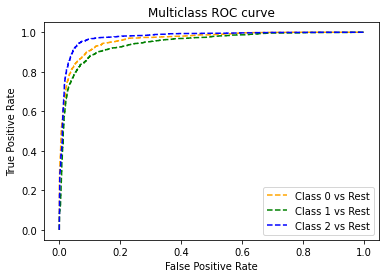

In [13]:
def svm(X_train, y_train, X_test, X_valid):
    clf = SVC(probability=True, C=1, kernel='linear')
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_

dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = svm(X_train, y_train, X_test, X_valid)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'SVM')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)

0.768658071545306


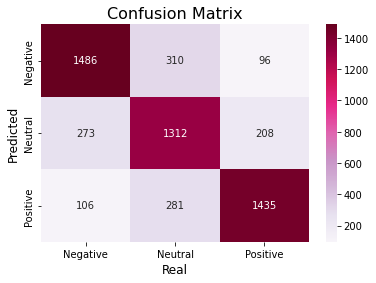

tp: 1312 tn: 1486 fp: 310 fn: 273
Accuracy: 0.828 Recall: 0.828 Precision: 0.809 F1-Score: 0.818 Sensitivity: 0.828 Specificity: 0.827
tp: 1096 tn: 1162 fp: 262 fn: 233
Accuracy: 0.82 Recall: 0.825 Precision: 0.807 F1-Score: 0.816 Sensitivity: 0.825 Specificity: 0.816
tp: 4559 tn: 4681 fp: 892 fn: 807
Accuracy: 0.845 Recall: 0.85 Precision: 0.836 F1-Score: 0.843 Sensitivity: 0.85 Specificity: 0.84


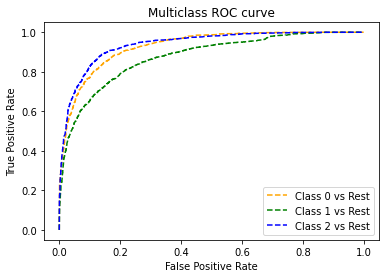

In [14]:
def boosting(X_train, y_train, X_test, X_valid):
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_test)
    return y_test_pred, y_valid_pred, y_train_pred, y_prob, clf.classes_

dt_pred, dt_valid_pred, dt_train_pred, y_prob, dt_classes = boosting(X_train, y_train, X_test, X_valid)
acc = accuracy_score(dt_pred, y_test.values)
print(acc)
cm = confusion_matrix(y_test.values, dt_pred)
plot_confusion(cm, 'SVR')
plt.show()
plt.clf()
multi_auc(y_prob, y_test)
compute_performance(dt_pred, y_test.values, dt_classes)
compute_performance(dt_valid_pred, y_valid.values, dt_classes)
compute_performance(dt_train_pred, y_train.values, dt_classes)

In [17]:
X=tweet["text"]
y=tweet["airline_sentiment"]

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=37,shuffle=True)


In [18]:
# we have to split each work with tokenizer based on space we also get the 10000 most repetitive words
tk = Tokenizer(num_words=numberofwords,
               split=" ")
tk.fit_on_texts(X_train)


In [19]:
#assign an int to each word
X_train_int = tk.texts_to_sequences(X_train)
X_test_int = tk.texts_to_sequences(X_test)



At this step we have to creat e one hot encoder based on the each integer that we retrievd from previous part for each word


In [20]:
def one_hot_encoder(word):
    one=np.zeros((len(word),numberofwords))
    for i, s in enumerate(word):
        one[i, s] = 1.
    return one


X_train_one = one_hot_encoder(X_train_int)
X_test_one = one_hot_encoder(X_test_int)

smote = SMOTE()
X_train_one, y_train = smote.fit_resample(X_train_one, y_train)
X_test_one, y_test = smote.fit_resample(X_test_one, y_test)
y_train_one = to_categorical(LabelEncoder().fit_transform(y_train))
y_test_one = to_categorical (LabelEncoder().fit_transform(y_test))

Splitting of a validation set


In [21]:
X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train_one, y_train_one, test_size=0.2, random_state=37)



In [22]:
# this is a base model for nueral network and we have make other models to campare with the basic ones and make the base model better
basic_model = models.Sequential()
basic_model.add(layers.Dense(64, activation='relu', input_shape=(numberofwords,)))
basic_model.add(layers.Dense(64, activation='relu'))
basic_model.add(layers.Dense(3, activation='softmax'))
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Now we have apply some inputs to our model also we have to fit that
def model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    fit_model = model.fit(X_train_v
                       , y_train_v
                       , epochs=numberofstartepochs
                       , batch_size=batchsize
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return fit_model

In [24]:
basic_graph = model(basic_model)


2021-12-18 01:15:56.214320: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 01:15:56.216077: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [25]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, numberofstartepochs + 1)
    plt.xlabel("Number of epochs")
    plt.plot(e, metric, label='Train ' + metric_name,color="red")
    plt.plot(e, val_metric, label='Validation ' + metric_name,color="green")
    plt.legend()
    plt.show()

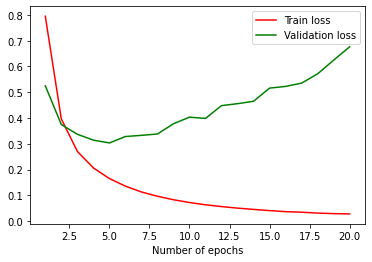

In [26]:
eval_metric(basic_graph, 'loss')




Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4.



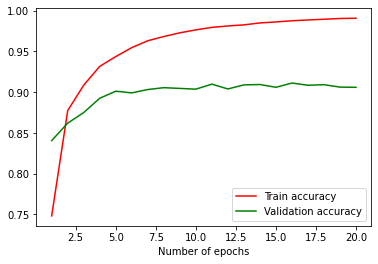

In [27]:
eval_metric(basic_graph, 'accuracy')


**Handling overfitting**

Now, we can try to do something about the overfitting. There are different options to do that.

Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers

Option 2: add regularization, which comes down to adding a cost to the loss function for large weights

Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

**Reducing the network's size**

We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [28]:
reduced = models.Sequential()
reduced.add(layers.Dense(32, activation='relu', input_shape=(numberofwords,)))
reduced.add(layers.Dense(3, activation='softmax'))
reduced.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# reduced_history = model(reduced)

In [29]:
def compare_loss_with_baseline(h, model_name):
    loss_basic_model = model(basic_model).history['val_loss']
    loss_model = h.history['val_loss']

    x = range(1, numberofstartepochs + 1)
    plt.xlabel("Number of epochs")
    plt.plot(x, loss_basic_model, label='Validation Loss Baseline Model')
    plt.plot(x, loss_model,  label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

In [30]:
reduced_graph = model(reduced)


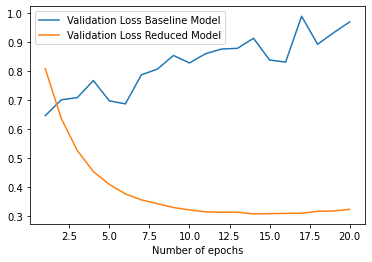

In [31]:
compare_loss_with_baseline(reduced_graph, 'Reduced Model')


**Adding regularization**

To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [32]:
regularization_l2 = models.Sequential()
regularization_l2.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(numberofwords,)))
regularization_l2.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
regularization_l2.add(layers.Dense(3, activation='softmax'))
regularization_l2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [33]:
reg2_graph = model(regularization_l2)


then we have to try with L1 regularization

In [34]:
regularization_l1 = models.Sequential()
regularization_l1.add(layers.Dense(64, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(numberofwords,)))
regularization_l1.add(layers.Dense(64, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
regularization_l1.add(layers.Dense(3, activation='softmax'))
regularization_l1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [35]:
reg1_graph = model(regularization_l1)

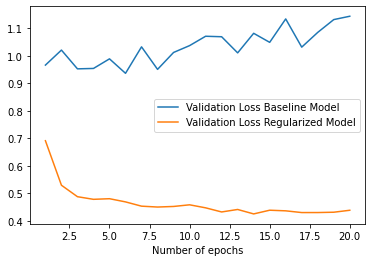

In [36]:
compare_loss_with_baseline(reg2_graph, 'Regularized Model')


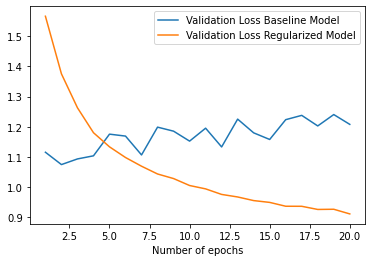

In [37]:
compare_loss_with_baseline(reg1_graph, 'Regularized Model')


Adding dropout layers

The last option we'll try is to add dropout layers.

In [38]:
dropout= models.Sequential()
dropout.add(layers.Dense(64, activation='relu', input_shape=(numberofwords,)))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(64, activation='relu'))
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(3, activation='softmax'))
dropout.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [39]:
drop_graph = model(dropout)


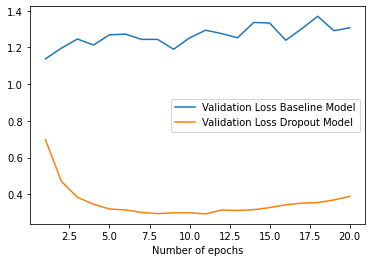

In [40]:
compare_loss_with_baseline(drop_graph, 'Dropout Model')


In [41]:
def compare_allloss(h1,h2,h3,h4):
    loss_basic_model = model(basic_model).history['val_loss']
    loss_model1 = h1.history['val_loss']
    loss_model2 = h2.history['val_loss']
    loss_model3 = h3.history['val_loss']
    loss_model4 = h4.history['val_loss']

    x = range(1, numberofstartepochs + 1)
    plt.xlabel("Number of epochs")
    plt.plot(x, loss_basic_model, label='Validation Loss Baseline Model')
    plt.plot(x, loss_model1,  label='Validation Loss drop out mode')
    plt.plot(x, loss_model2,  label='Validation Loss reduced model')
    plt.plot(x, loss_model3,  label='Validation Loss regularizion losso model')
    plt.plot(x, loss_model4,  label='Validation Loss regularization ridge model')

    plt.legend()
    plt.show()

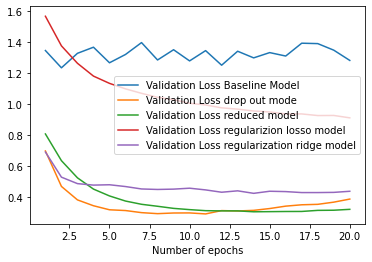

In [42]:
compare_allloss(drop_graph,reduced_graph,reg1_graph, reg2_graph)


In [43]:
def test_model(model, epoch_stop):
    model.fit(X_train_v
              , y_train_v
              , epochs=epoch_stop
              , batch_size=batchsize
              , verbose=0)
    results = model.evaluate(X_test_one, y_test_one)
    
    return results

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

we can see that

Training on the full train data and evaluation on test data

At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.


In [44]:
basicmodel_result = test_model(basic_model, 6)
print('/n')
print(basicmodel_result[1])
# print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

5586/5586 [==============================] - 0s 70us/step
/n
0.6970998644828796


In [45]:
reducedmodel_result = test_model(reduced, 4)
print(reducedmodel_result[1])
# print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

5586/5586 [==============================] - 0s 36us/step
0.7531328201293945


In [46]:
regularization_l1_results = test_model(regularization_l1, 19)
print(regularization_l1_results[1])
# print('Test accuracy of regularized model: {0:.2f}%'.format(regularization_l1_results[1]*100))

5586/5586 [==============================] - 0s 71us/step
0.7647690773010254


In [47]:
regularization_l2_results = test_model(regularization_l2, 19)
print(regularization_l2_results[1])

5586/5586 [==============================] - 0s 81us/step
0.7737200260162354


In [48]:
dropout_results = test_model(dropout, 10)
print(dropout_results[1])
# print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

5586/5586 [==============================] - 0s 56us/step
0.7595775127410889


#######################################